In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 26

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [15]:
from tensorflow.keras.layers import BatchNormalization

model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [16]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,074 (23.73 KB)

 Trainable params: 5,882 (22.98 KB)

 Non-trainable params: 192 (768.00 B)

In [17]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [18]:
# Model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [19]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
109/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0789 - loss: 3.3948
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0910 - loss: 3.3312 - val_accuracy: 0.2978 - val_loss: 2.4992
Epoch 2/1000
124/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3168 - loss: 2.2748
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3178 - loss: 2.2693 - val_accuracy: 0.5379 - val_loss: 1.6464
Epoch 3/1000
117/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4059 - loss: 1.8515
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4072 - loss: 1.8467 - val_accuracy: 0.6389 - val_loss: 1.2133
Epoch 4/1000
123/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4587 - loss: 1.6384
Epoch 4: saving model to model/keypoint_classifier/keypoint_classi

In [20]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.8396 - loss: 0.5392


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[4.5722958e-02 3.9167199e-03 7.8371388e-04 5.6174546e-03 4.1529462e-02
 1.1445935e-03 1.3739713e-05 4.6993036e-06 3.2183964e-02 7.7185379e-03
 9.0765512e-05 5.0024065e-04 1.6292576e-04 1.0840933e-04 2.5247759e-03
 8.5465563e-06 9.6188151e-06 8.3482312e-03 1.8875928e-01 2.8901657e-01
 2.7033847e-04 3.0729568e-04 3.3149356e-04 2.1156600e-01 1.3352221e-01
 2.5837475e-02]
19


# Confusion matrix

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


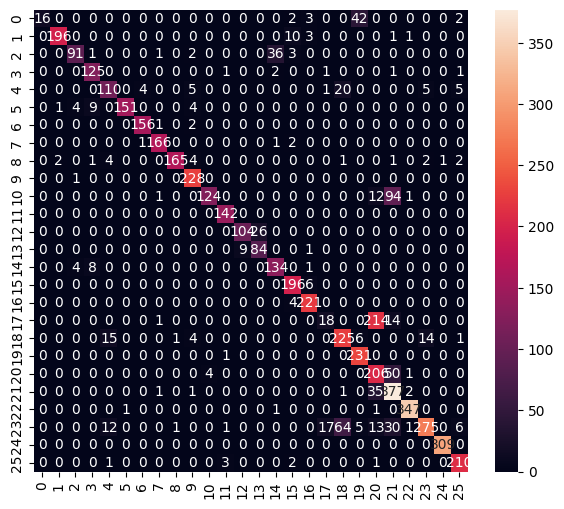

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        65
           1       0.98      0.93      0.96       211
           2       0.91      0.68      0.78       134
           3       0.87      0.95      0.91       131
           4       0.77      0.73      0.75       150
           5       0.99      0.89      0.94       169
           6       0.97      0.98      0.97       159
           7       0.97      0.98      0.97       170
           8       0.99      0.90      0.94       183
           9       0.91      1.00      0.95       229
          10       0.97      0.53      0.69       232
          11       0.96      1.00      0.98       142
          12       0.92      0.80      0.86       130
          13       0.76      0.89      0.82        94
          14       0.77      0.91      0.83       147
          15       0.89      0.97      0.93       202
          16       0.94      0.98      0.96       225
     

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpruxjxd_l\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpruxjxd_l\assets


Saved artifact at 'C:\Users\user\AppData\Local\Temp\tmpruxjxd_l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  1684746673168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1684746674704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1684746675280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1684780309328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1684780306640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1684780305488: TensorSpec(shape=(), dtype=tf.resource, name=None)


7504

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 5 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.57229614e-02 3.91671900e-03 7.83712952e-04 5.61745092e-03
 4.15294357e-02 1.14459218e-03 1.37397237e-05 4.69930319e-06
 3.21839377e-02 7.71853654e-03 9.07655849e-05 5.00241527e-04
 1.62925731e-04 1.08409266e-04 2.52477312e-03 8.54654627e-06
 9.61881324e-06 8.34823400e-03 1.88759208e-01 2.89016813e-01
 2.70338962e-04 3.07295908e-04 3.31493502e-04 2.11565971e-01
 1.33522093e-01 2.58374587e-02]
19


# Some Graph readings here

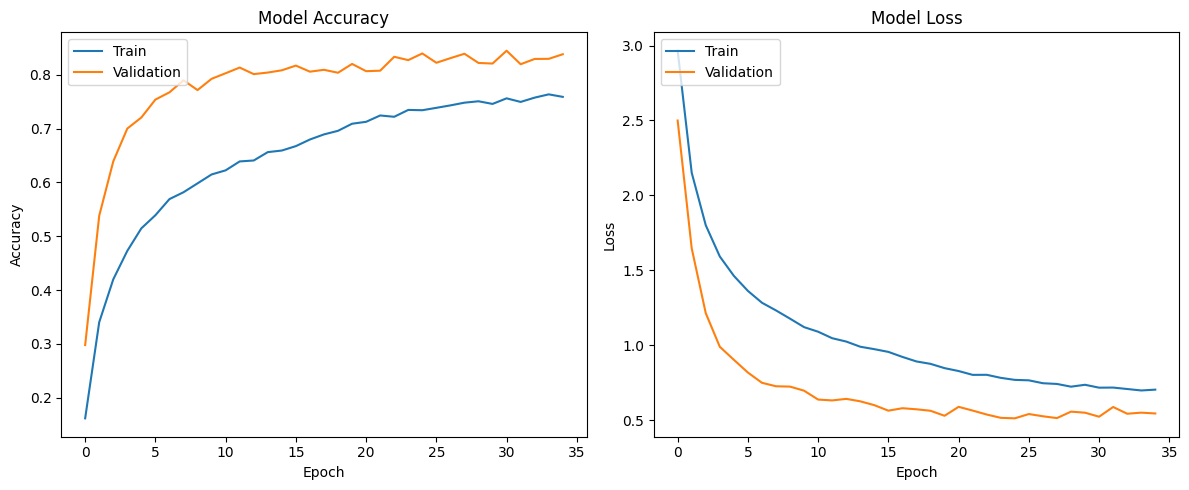

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()  